In [3]:
### Install dependencies
!pip install afinn pymc arviz scikit-learn pgmpy nltk textblob requests datasets numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
 

In [31]:
### Imports

# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import multiprocessing


# Data & vectorization
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    classification_report
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression



# Bayesian modeling
import pymc as pm
import arviz as az

# Graphical models
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination

# Text processing & lexicons
from afinn import Afinn
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from textblob import TextBlob

# Special math functions
from scipy.special import logsumexp, digamma, polygamma
from scipy.stats import norm
from scipy.special import gammaln


n_cpus = multiprocessing.cpu_count()  # usually 2 on free Colab



# NLTK downloads (only needed once)
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
!wget -q https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-111.txt -O AFINN-111.txt

In [6]:
# Load data

# Load the first 1 000 examples of the “yelp_review_full” train split
ds = load_dataset(
    "Yelp/yelp_review_full",      # dataset repo on Hugging-Face
    "yelp_review_full",           # config name
    split="train[:1000]"         # only the first 1000 rows
)

texts = ds["text"]           # list of strings
labels = ds["label"]         # list of ints 0–4

# 2) Convert to NumPy array
labels_arr = np.array(labels)

# 3) Drop neutrals (rating == 2)
mask = labels_arr != 2
texts = [t for t, m in zip(texts, mask) if m]
labels_arr = labels_arr[mask]

# 4) Dichotomize: ratings 0–1 → 0, 3–4 → 1
binary_labels = (labels_arr >= 3).astype(int)

# 5) Overwrite for downstream use
labels = binary_labels

# 6) Quick sanity check
unique, counts = np.unique(labels, return_counts=True)
print(f"Kept {len(texts)} reviews after dropping neutrals.")
print("Binary label distribution:", dict(zip(unique, counts)))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Kept 792 reviews after dropping neutrals.
Binary label distribution: {np.int64(0): np.int64(429), np.int64(1): np.int64(363)}


In [7]:
labels

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,

# Raw Log-odds vs. Fightin' Words (Monroe et al., 2008).

**Raw Log-odds**

## 1. Raw Log-Odds Ratio

Suppose you have two corpora, **A** (e.g. negative reviews) and **B** (positive reviews).  For each word \(j\):

- $n_j^{(A)}$ -- total count of word $j$ in corpus A
- $n_j^{(B)}$ -- total count of word $j$ in corpus B
- $N^{(A)} = \sum_{k} n_k^{(A)}$ — total words in corpus A
- $N^{(B)} = \sum_{k} n_k^{(B)}$ — total words in corpus B
- $\varepsilon$ — small constant added to avoid $log(0)$


\begin{aligned}
\mathrm{log\text{-}odds}_j
&= \log\!\bigl(\tfrac{n_j^{(B)}/N^{(B)}}{\,n_j^{(A)}/N^{(A)}}\bigr)\\
&= \bigl[\log(n_j^{(B)} + \varepsilon) - \log(N^{(B)})\bigr]
  \;-\;
  \bigl[\log(n_j^{(A)} + \varepsilon) - \log(N^{(A)})\bigr].
\end{aligned}

Words with $\mathrm{log\text{-}odds}_j \gg 0$ are much more frequent in corpus B, while those with $\mathrm{log\text{-}odds}_j \ll 0$ are more frequent in corpus A.

In [91]:
# Vectorize to counts
vectorizer = CountVectorizer(max_features=2000, stop_words="english")
counts = vectorizer.fit_transform(texts).toarray()
words = vectorizer.get_feature_names_out()
V = counts.shape[1]

# Split into negative (A) and positive (B)
counts_A = counts[labels == 0]
counts_B = counts[labels == 1]

In [92]:
counts.shape

(792, 2000)

In [93]:
# 3) Compute raw log-odds ratio (no smoothing)
nA = counts_A.sum(axis=0)
nB = counts_B.sum(axis=0)
N_A = nA.sum()
N_B = nB.sum()
epsilon = 1e-6  # to avoid log(0)
freqA = (nA / N_A) + epsilon
freqB = (nB / N_B) + epsilon
log_odds_ratio = np.log(freqB / freqA)

# 4) Overall word frequency
frequency = counts.sum(axis=0)

In [94]:
# 5) Build DataFrame
df_raw = pd.DataFrame({
    "word": words,
    "log_odds_ratio": log_odds_ratio,
    "frequency": frequency
})

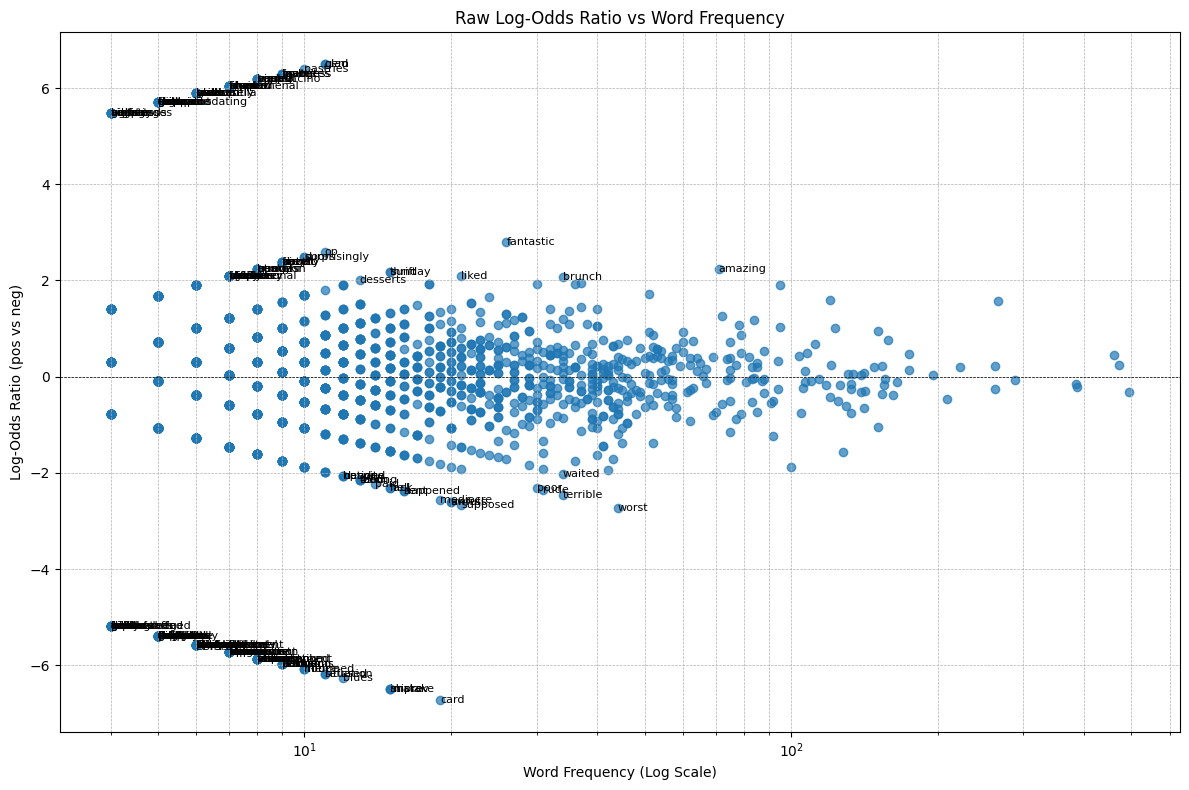

In [95]:
# 6) Label words with large log-odds
threshold = 2.0
df_raw["label"] = df_raw["word"].where(df_raw["log_odds_ratio"].abs() > threshold, "")

# 7) Scatter plot: frequency vs log-odds ratio
plt.figure(figsize=(12, 8))
plt.scatter(df_raw["frequency"], df_raw["log_odds_ratio"], alpha=0.7)
for _, row in df_raw.iterrows():
    if row["label"]:
        plt.text(row["frequency"], row["log_odds_ratio"], row["label"], fontsize=8, va="center")

plt.xscale("log")
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.xlabel("Word Frequency (Log Scale)")
plt.ylabel("Log-Odds Ratio (pos vs neg)")
plt.title("Raw Log-Odds Ratio vs Word Frequency")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## Bayesian-smoothed (Dirichlet prior) log-odds (Fightin' Words)


Let corpora A and B have word counts

- $n_j^{(A)}$, $n_j^{(B)}$

and total tokens
- $N^{(A)} = \sum_{k=1}^V n_k^{(A)}$,
- $N^{(B)} = \sum_{k=1}^V n_k^{(B)}$


Posterior pseudo-counts

$$a_j^{(X)} = \alpha + n_j^{(X)},\qquad
A^{(X)} = \sum_{k=1}^V a_k^{(X)} = \alpha,V + N^{(X)},
\quad X\in{A,B}.$$



Smoothed log-odds difference
$$
\delta_j
= \bigl[\psi\bigl(a_j^{(B)}\bigr) - \psi\bigl(A^{(B)}\bigr)\bigr]
-
\bigl[\psi\bigl(a_j^{(A)}\bigr) - \psi\bigl(A^{(A)}\bigr)\bigr],
$$
where $\psi$ is the digamma function



Approximate variance

$$
\mathrm{Var}(\delta_j)
= \psi^{(1)}\bigl(a_j^{(B)}\bigr) + \psi^{(1)}\bigl(A^{(B)}\bigr)
+
\psi^{(1)}\bigl(a_j^{(A)}\bigr) + \psi^{(1)}\bigl(A^{(A)}\bigr),
$$
with $\psi^{(1)}$ the trigamma.
	4.	Standardized $z$-score
$$
z_j =\frac{\delta_j}{\sqrt{\mathrm{Var}(\delta_j)}}.
$$


In [96]:
# 2) Vectorize to counts
vectorizer = CountVectorizer(max_features=2000, stop_words="english")
counts = vectorizer.fit_transform(texts).toarray()
words = vectorizer.get_feature_names_out()
V = counts.shape[1]

# 3) Split into negative (A) and positive (B)
counts_A = counts[labels == 0]
counts_B = counts[labels == 1]

# 4) Bayesian-smoothed log-odds difference (δ)
alpha = 0.5
nA = counts_A.sum(axis=0)
nB = counts_B.sum(axis=0)
aA = alpha + nA
bA = alpha * V + nA.sum() - aA
aB = alpha + nB
bB = alpha * V + nB.sum() - aB

delta = (digamma(aB) - digamma(bB)) - (digamma(aA) - digamma(bA))

# 5) Overall word frequency
frequency = counts.sum(axis=0)

In [97]:

# 6) Assemble DataFrame
df = pd.DataFrame({
    "word": words,
    "delta": delta,
    "frequency": frequency
})


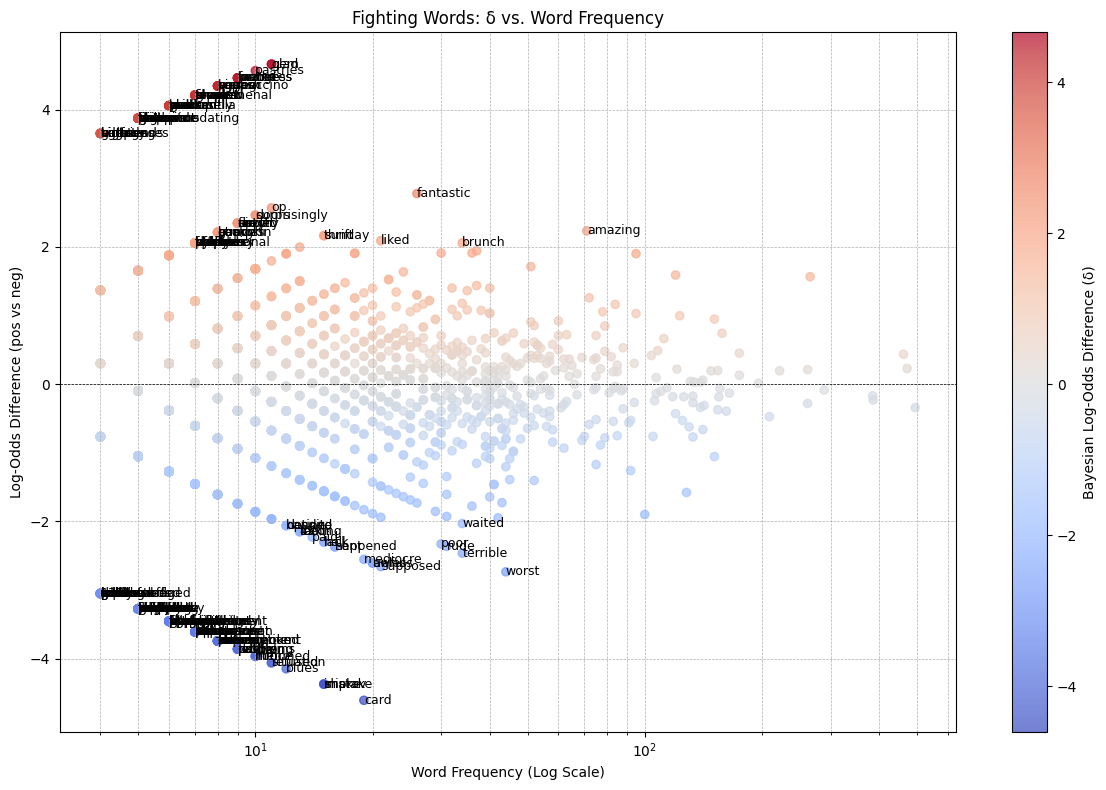

In [98]:

# 7) Label only extreme δ for annotation
threshold = 2.0
df["label"] = df["word"].where(df["delta"].abs() > threshold, "")

# 8) Scatter plot: frequency vs δ
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    df["frequency"],
    df["delta"],
    c=df["delta"],
    cmap="coolwarm",
    alpha=0.7
)
plt.colorbar(sc, label="Bayesian Log-Odds Difference (δ)")

for _, row in df.iterrows():
    if row["label"]:
        plt.text(
            row["frequency"],
            row["delta"],
            row["label"],
            fontsize=9,
            va="center"
        )

plt.xscale("log")
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.xlabel("Word Frequency (Log Scale)")
plt.ylabel("Log-Odds Difference (pos vs neg)")
plt.title("Fighting Words: δ vs. Word Frequency")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

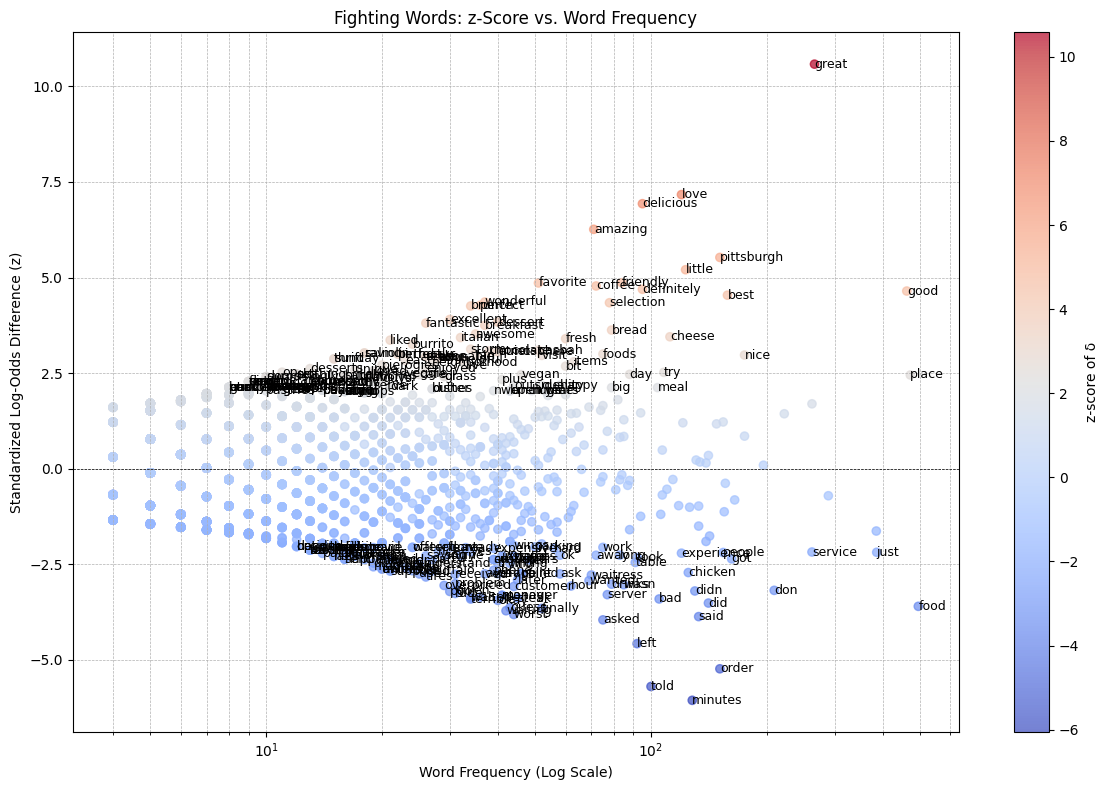

In [100]:
# 6) Compute variance & z-score
var_delta = polygamma(1, aB) + polygamma(1, bB) + polygamma(1, aA) + polygamma(1, bA)
z_score   = delta / np.sqrt(var_delta)

# 7) Build DataFrame with z_score
df = pd.DataFrame({
    "word":      words,
    "delta":     delta,
    "z_score":   z_score,
    "frequency": frequency
})

# 8) Label extreme |z| for annotation
z_thresh = 2.0
df["label"] = df["word"].where(df["z_score"].abs() > z_thresh, "")

# 9) Scatterplot: frequency vs z-score
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    df["frequency"],
    df["z_score"],
    c=df["z_score"],
    cmap="coolwarm",
    alpha=0.7
)
plt.colorbar(sc, label="z-score of δ")

for _, row in df.iterrows():
    if row["label"]:
        plt.text(row["frequency"], row["z_score"], row["label"], fontsize=9, va="center")

plt.xscale("log")
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.xlabel("Word Frequency (Log Scale)")
plt.ylabel("Standardized Log-Odds Difference (z)")
plt.title("Fighting Words: z-Score vs. Word Frequency")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## Bayesian Linear Regression in PyMC

We’ll fit the simple model


\begin{aligned}
  \alpha &\sim \mathcal{N}(0,\,10) \quad\text{(intercept prior)}\\
  \beta  &\sim \mathcal{N}(0,\,10) \quad\text{(slope prior)}\\
  \sigma &\sim \mathrm{HalfNormal}(5)\quad\text{(noise scale prior)}\\
  y_i \mid \alpha,\beta,\sigma &\sim \mathcal{N}\bigl(\mu_i,\;\sigma^2\bigr),\quad
    \mu_i = \alpha + \beta\,x_i.
\end{aligned}



**Simulate data**  
   We generate (N=50) points from $y = \alpha + \beta x + \varepsilon$.



In [104]:
# 1) Simulate synthetic data for simple linear regression
np.random.seed(42)
N = 50
x = np.linspace(0, 10, N)
true_alpha = 1.0
true_beta = 2.5
true_sigma = 1.0
y = true_alpha + true_beta * x + np.random.normal(0, true_sigma, size=N)

# 2) Build and fit Bayesian linear model in PyMC
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(
        draws=1000, tune=1000,
        chains=n_cpus,    # run as many chains as you have CPUs
        cores=n_cpus,     # use all CPUs
        target_accept=0.9, random_seed=42
    )


Output()

In [102]:

# 3) Summarize posterior
alpha_samples = trace.posterior["alpha"].values.flatten()
beta_samples = trace.posterior["beta"].values.flatten()
sigma_samples = trace.posterior["sigma"].values.flatten()

posterior_summary = pd.DataFrame({
    "parameter": ["alpha", "beta", "sigma"],
    "mean": [alpha_samples.mean(), beta_samples.mean(), sigma_samples.mean()],
    "sd": [alpha_samples.std(), beta_samples.std(), sigma_samples.std()],
    "2.5%": [np.percentile(alpha_samples, 2.5),
             np.percentile(beta_samples, 2.5),
             np.percentile(sigma_samples, 2.5)],
    "97.5%": [np.percentile(alpha_samples, 97.5),
              np.percentile(beta_samples, 97.5),
              np.percentile(sigma_samples, 97.5)]
})

print(posterior_summary)

  parameter      mean        sd      2.5%     97.5%
0     alpha  1.066140  0.261890  0.549278  1.570286
1      beta  2.441717  0.045295  2.349397  2.532427
2     sigma  0.951506  0.095139  0.780423  1.156876


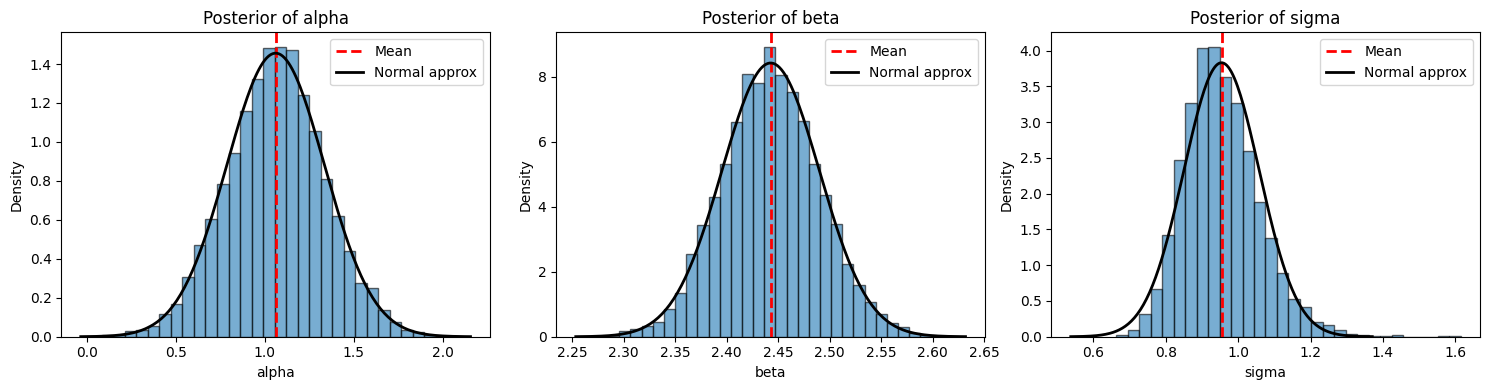

In [77]:
params = {
    "alpha": alpha_samples,
    "beta": beta_samples,
    "sigma": sigma_samples
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, samples) in zip(axes, params.items()):
    ax.hist(samples, bins=30, density=True, alpha=0.6, edgecolor='k')
    mu = samples.mean()
    sd = samples.std()
    ax.axvline(mu, color='red', linestyle='--', lw=2, label='Mean')
    x_vals = np.linspace(mu - 4*sd, mu + 4*sd, 200)
    ax.plot(x_vals, norm.pdf(x_vals, mu, sd), 'k-', lw=2, label='Normal approx')
    ax.set_title(f"Posterior of {name}")
    ax.set_xlabel(name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

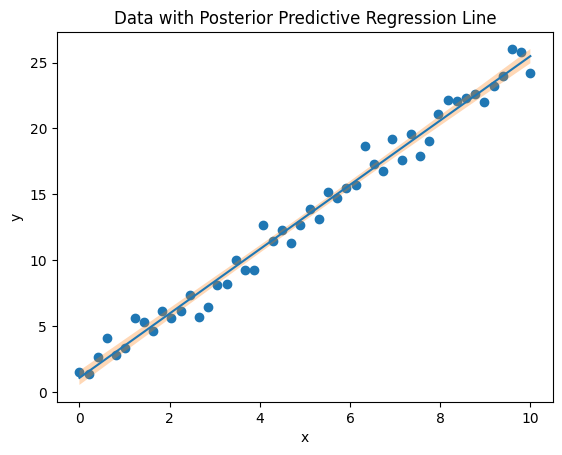

In [78]:
# 5) Posterior predictive regression line with credible interval
x_new = np.linspace(x.min(), x.max(), 100)
# Construct matrix of predictions: shape (n_samples, n_xnew)
y_preds = alpha_samples[:, None] + beta_samples[:, None] * x_new[None, :]

mean_pred = y_preds.mean(axis=0)
lower_pred = np.percentile(y_preds, 2.5, axis=0)
upper_pred = np.percentile(y_preds, 97.5, axis=0)

plt.figure()
plt.scatter(x, y)
plt.plot(x_new, mean_pred)
plt.fill_between(x_new, lower_pred, upper_pred, alpha=0.3)
plt.title("Data with Posterior Predictive Regression Line")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

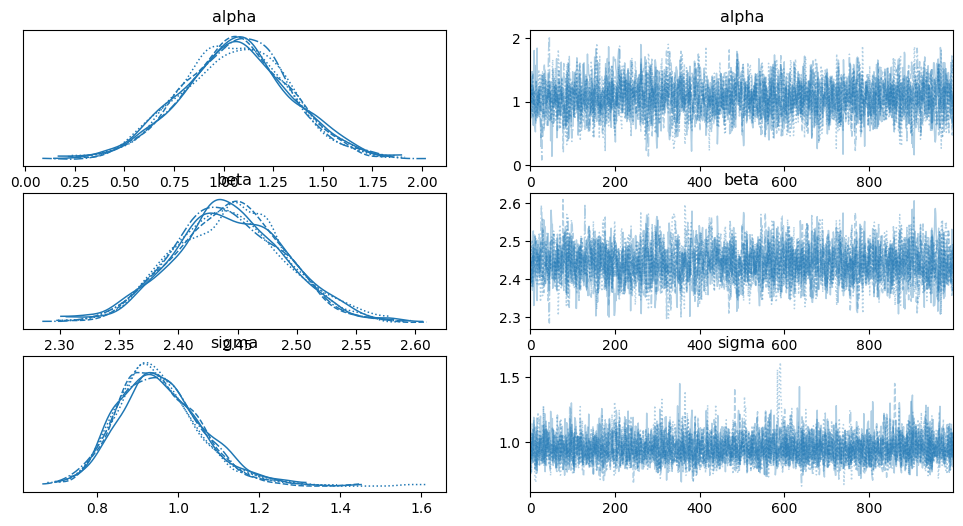

In [79]:
az.plot_trace(trace, var_names=['alpha', 'beta', 'sigma'])
plt.show()

# Text Analysis Models

## Lexicon-Informed Dirichlet–Multinomial Mixture

We model each review as coming from a two-component mixture of bag‐of‐words distributions (“negative” vs. “positive”), where each component’s word‐distribution is seeded by the AFINN lexicon.


###Build Dirichlet priors from AFINN (or any other dictionary):

For each vocabulary word $j$, let its AFINN score be


$s_j \;=\;\begin{cases}
\text{AFINN}(w_j) &\text{if }w_j\in\text{AFINN,}\\
0 &\text{otherwise.}
\end{cases}$


Choose a tuning hyperparameter $\kappa>0$. Then define

$\alpha^{(\text{pos})}_j
=1 + \kappa\,\max(s_j,0),
\qquad
\alpha^{(\text{neg})}_j
=1 + \kappa\,\max(-s_j,0)
$

###Generative model

Class prior
$\pi \;\sim\;\mathrm{Beta}(1,1)$

Word distributions

$\phi_{\text{neg}}
\;\sim\;\mathrm{Dirichlet}\bigl(\alpha^{(\text{neg})}_1,\dots,\alpha^{(\text{neg})}_V\bigr),
\quad
\phi_{\text{pos}}
\;\sim\;\mathrm{Dirichlet}\bigl(\alpha^{(\text{pos})}_1,\dots,\alpha^{(\text{pos})}_V\bigr)$


###Document generation

For each document $d$:

- Let $n_d=\sum_j c_{d,j}$ be its total word‐count.
- Draw its counts from the two-component mixture:
$c_d
\;\sim\;
(1-\pi)\,\mathrm{Multinomial}\bigl(n_d,\phi_{\text{neg}}\bigr)
\;+\;
\pi\,\mathrm{Multinomial}\bigl(n_d,\phi_{\text{pos}}\bigr).$



In [9]:


# 1) Load AFINN lexicon from local file
lexicon = {}
with open("AFINN-111.txt", encoding="utf-8") as f:
    for line in f:
        word, score = line.strip().split('\t')
        lexicon[word] = int(score)


# 4) Vectorize to get document–word counts
vect   = CountVectorizer(max_features=2000, stop_words="english")
counts = vect.fit_transform(texts).toarray()
words  = vect.get_feature_names_out()
D, V   = counts.shape
n_words = counts.sum(axis=1)

# 5) Build Dirichlet priors from AFINN scores
scores     = np.array([lexicon.get(w, 0) for w in words])
scores_arr = counts.dot(scores)

kappa = 15
alpha_pos = 1 + kappa * np.clip(scores, 0, None)
alpha_neg = 1 + kappa * np.clip(-scores, 0, None)




In [ ]:

# 6) Two‑mixture model in PyMC
with pm.Model() as sentiment_model:
    pi       = pm.Beta("pi", 1, 1)
    phi_neg  = pm.Dirichlet("phi_neg", a=alpha_neg, shape=V)
    phi_pos  = pm.Dirichlet("phi_pos", a=alpha_pos, shape=V)

    comp_neg = pm.Multinomial.dist(n=n_words, p=phi_neg, size=D)
    comp_pos = pm.Multinomial.dist(n=n_words, p=phi_pos, size=D)

    pm.Mixture("obs",
               w=[1 - pi, pi],
               comp_dists=[comp_neg, comp_pos],
               observed=counts)

    # ADVI (fast) — replace with pm.sample(...) for full MCMC
    approx = pm.fit(2000, method="advi", random_seed=42)
    trace  = approx.sample(500)

# compiled_model = nutpie.compile_pymc_model(sentiment_model)
# trace = nutpie.sample(compiled_model)


In [133]:

# 7) Compute posterior P(positive) per document
phi_neg_samps = trace.posterior["phi_neg"].stack(s=("chain","draw")).values.T  # (S, V)
phi_pos_samps = trace.posterior["phi_pos"].stack(s=("chain","draw")).values.T
pi_samps      = trace.posterior["pi"].stack(s=("chain","draw")).values.flatten()

# Prepare arrays for mean and 95% credible bounds
post_mean  = np.zeros(D)
post_lower = np.zeros(D)
post_upper = np.zeros(D)

# Monte Carlo over posterior samples
for d in range(D):
    c = counts[d]  # word‐count vector for doc d

    # log-likelihoods under each sample s
    ll0 = (c * np.log(phi_neg_samps)).sum(axis=1)      # neg component
    ll1 = (c * np.log(phi_pos_samps)).sum(axis=1)      # pos component

    # add log-prior weights
    log0 = np.log(1 - pi_samps) + ll0
    log1 = np.log(pi_samps)       + ll1

    # normalize to get probabilities
    norm = logsumexp([log0, log1], axis=0)
    p_samps = np.exp(log1 - norm)  # shape (S,)

    # summarize
    post_mean[d]  = p_samps.mean()
    post_lower[d] = np.percentile(p_samps, 2.5)
    post_upper[d] = np.percentile(p_samps, 97.5)

,afinn_score,post_pos_mean,post_pos_lower,post_pos_upper
0,6,0.890126,8.538816e-93,1.0
1,-4,0.151489,1.465559e-141,1.0
2,4,0.813031,1.988684e-83,1.0
3,-3,0.195720,6.559068e-76,1.0
4,1,0.354288,1.169139e-250,1.0
...,...,...,...,...
787,39,0.960000,0.000000e+00,1.0
788,21,0.711095,0.000000e+00,1.0
789,14,0.679342,2.347692e-201,1.0
790,18,0.960011,1.995729e-91,1.0


In [134]:
# check results
df = pd.DataFrame({
    'text'       :    texts,
    'afinn_score':    counts.dot(scores),
    'post_pos_mean':  post_mean,
    'post_pos_lower': post_lower,
    'post_pos_upper': post_upper
})

df['text_snippet'] = df['text'].str[:100]

print(df.head()[['text_snippet', 'afinn_score', 'post_pos_mean', 'post_pos_lower', 'post_pos_upper']].to_markdown(index=False))

| text_snippet                                                                                         |   afinn_score |   post_pos_mean |   post_pos_lower |   post_pos_upper |
|:-----------------------------------------------------------------------------------------------------|--------------:|----------------:|-----------------:|-----------------:|
| dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to  |             6 |        0.890126 |     8.53882e-93  |                1 |
| Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've ha |            -4 |        0.151489 |     1.46556e-141 |                1 |
| Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started  |             4 |        0.813031 |     1.98868e-83  |                1 |
| Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new positio |           

AUPRC (Average Precision): 0.784


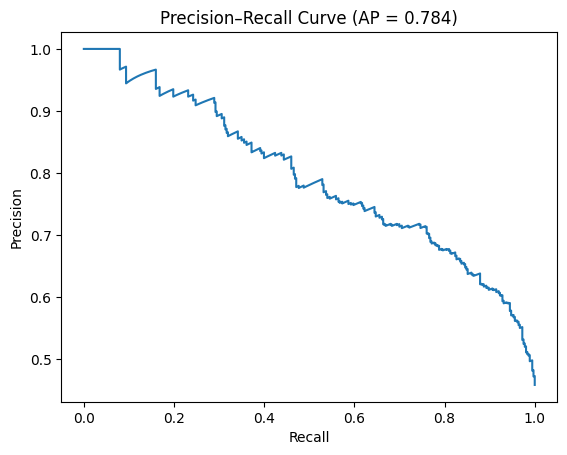

In [135]:
# true_labels: your ground-truth 0/1 array for each document
# post_pos_mean:  model’s posterior P(positive) mean for each document

# Compute AUPRC (average precision)
ap = average_precision_score(labels, post_mean)
print(f"AUPRC (Average Precision): {ap:.3f}")

# Plot Precision–Recall curve
precision, recall, _ = precision_recall_curve(labels, post_pos)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.show()

In [142]:
len(vect.get_feature_names_out())
len(lower)

500

In [143]:
# 1) Pull out raw posterior samples: shape (chains, draws, V)
phi_neg = trace.posterior["phi_neg"].values    # e.g. (2, 250, V)
phi_pos = trace.posterior["phi_pos"].values

# 2) Reshape to (S, V) where S = chains*draws
chains, draws, V = phi_neg.shape
S = chains * draws
phi_neg_samps = phi_neg.reshape(S, V)
phi_pos_samps = phi_pos.reshape(S, V)

# 3) Compute posterior means per word: arrays of length V
phi_neg_mean = phi_neg_samps.mean(axis=0)   # (V,)
phi_pos_mean = phi_pos_samps.mean(axis=0)

# 4) Log-odds difference per word
delta = np.log(phi_pos_mean) - np.log(phi_neg_mean)  # (V,)

# 5) Credible intervals for log-odds
delta_samps = np.log(phi_pos_samps) - np.log(phi_neg_samps)  # (S, V)
lower = np.percentile(delta_samps, 2.5, axis=0)   # (V,)
upper = np.percentile(delta_samps, 97.5, axis=0)  # (V,)

# 6) Build the DataFrame
df_imp = pd.DataFrame({
    "word":      vect.get_feature_names_out(),  # length V
    "delta":     delta,                         # length V
    "ci_lower":  lower,                         # length V
    "ci_upper":  upper                          # length V
})

# 7) Inspect top and bottom words
print("Top positive indicators:")
print(df_imp.nlargest(10, "delta").to_string(index=False))

print("\nTop negative indicators:")
print(df_imp.nsmallest(10, "delta").to_string(index=False))

Top positive indicators:
       word    delta  ci_lower  ci_upper
outstanding 4.098843 -3.529446 16.943392
      funny 3.906649 -4.971630 17.406542
        wow 3.863865 -4.202959 16.892951
  wonderful 3.847167 -4.923151 17.945080
    awesome 3.844792 -5.976652 17.930695
  fantastic 3.825827 -4.716123 16.547711
    amazing 3.770785 -4.849932 17.882289
        fun 3.707029 -5.231848 17.286782
      lucky 3.699790 -6.476287 16.047542
  impressed 3.678509 -4.919898 16.095929

Top negative indicators:
      word     delta   ci_lower  ci_upper
     bitch -4.288404 -12.854972  8.564927
      damn -4.076821 -12.523222  8.632505
       ass -4.063309 -14.351400  9.042823
      hell -4.030336 -12.996954  8.803619
     sucks -3.971553 -12.612330 10.829933
ridiculous -3.926234 -12.225176  9.347839
 miserable -3.918781 -11.683867  8.727920
     nasty -3.898077 -12.459687 10.187672
   charged -3.885644 -12.131639  8.877584
    damage -3.870026 -12.883421 10.469567


# Comparing the Bayesian Model with raw Dictionary approach

Dictionary (calibrated) AP: 0.693
Bayesian model       AP: 0.784


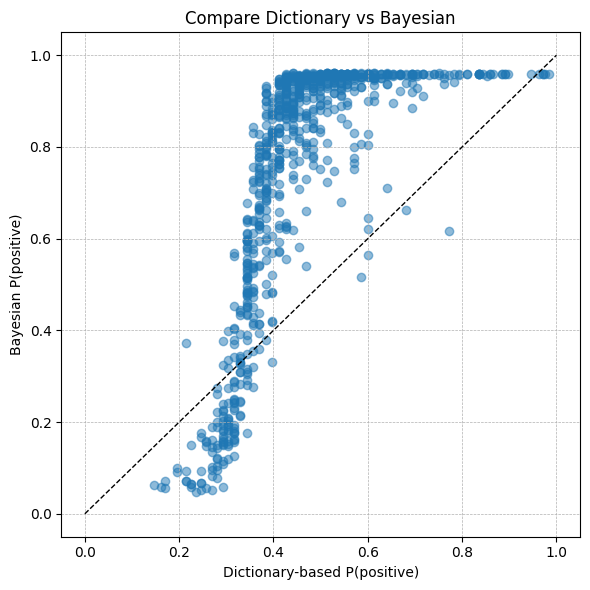

| text_snippet                                                                                                                                                                                             |   afinn_score |   dict_prob |   bayes_prob |   bayes_lower |   bayes_upper |
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|------------:|-------------:|--------------:|--------------:|
| dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-no |             6 |    0.42595  |     0.890126 |  8.53882e-93  |             1 |
| Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, 

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import average_precision_score

# 1) Compute raw AFINN scores per document
#    (counts: D×V matrix, scores: length V array)
dict_score = counts.dot(scores)

# 2) Calibrate via logistic regression on your true binary labels
lr = LogisticRegressionCV(
    cv=5,
    scoring='average_precision',
    solver='lbfgs',
    max_iter=1000
).fit(dict_score.reshape(-1, 1), labels)
dict_prob = lr.predict_proba(dict_score.reshape(-1, 1))[:, 1]

# 3) Build comparison DataFrame
df_cmp = pd.DataFrame({
    'text_snippet': [t[:200] for t in texts],
    'afinn_score':  dict_score,
    'dict_prob':    dict_prob,
    'bayes_prob':   post_mean,    # posterior mean from Bayesian model
    'bayes_lower':  post_lower,   # 2.5% CI
    'bayes_upper':  post_upper    # 97.5% CI
})

# 4) Evaluate average precision (AUPRC)
ap_dict  = average_precision_score(labels, dict_prob)
ap_bayes = average_precision_score(labels, post_mean)
print(f"Dictionary (calibrated) AP: {ap_dict:.3f}")
print(f"Bayesian model       AP: {ap_bayes:.3f}")

# 5) Scatter plot comparison
plt.figure(figsize=(6, 6))
plt.scatter(dict_prob, post_mean, alpha=0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('Dictionary-based P(positive)')
plt.ylabel('Bayesian P(positive)')
plt.title('Compare Dictionary vs Bayesian')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 6) Show a few rows of the comparison
print(df_cmp.head().to_markdown(index=False))

## Supervised Logistic Regression

A supervised Bayesian logistic regression using the AFINN score as a single feature, and then carries that posterior over to make predictions on both labeled and unlabeled documents

In [43]:
N = len(texts)


# 1) Split off 100 labeled docs, keep the rest as “unlabeled”
s_l, s_u, y_l, y_u, idx_l, idx_u = train_test_split(
    scores_arr, labels, np.arange(N),
    train_size=600,
    random_state=42,
    stratify=labels
)

	•	Inputs to train_test_split: three parallel arrays of length N:
	1.	scores_arr (senitiment scores),
	2.	labels (the ground‐truth 0/1),
	3.	np.arange(N) (just the document indices).
	•	Outputs (in order):
	1.	s_l: the 500 “labeled” feature values,
	2.	s_u: the remaining N-500 “unlabeled” feature values,
	3.	y_l: the 500 labels you’ll actually fit on,
	4.	y_u: the labels for the “unlabeled” docs (kept if you want to evaluate later),
	5.	idx_l: the original indices of those 500 labeled docs,
	6.	idx_u: the original indices of the “unlabeled” docs.


  By doing this, we can train a Bayesian logistic model on the small “labeled” slice (s_l, y_l) and then predict (or examine uncertainty) on the rest (s_u, using idx_u to map back to the full corpus).

In [44]:
# 2) Bayesian logistic regression on the labeled subset

# standardize
s_mean, s_std = s_l.mean(), s_l.std()
s_l_std = (s_l - s_mean) / s_std

with pm.Model() as semi_model_std:
    alpha = pm.Normal("alpha", 0, 5)
    beta  = pm.Normal("beta",  0, 5)
    logit_p = alpha + beta * s_l_std
    pm.Bernoulli("y_obs", logit_p=logit_p, observed=y_l)

    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        max_treedepth=15,
        random_seed=666
    )


Output()

In [45]:


# 3) Posterior predictive P(positive) for ALL N docs
a_samps = trace.posterior["alpha"].stack(s=("chain","draw")).values
b_samps = trace.posterior["beta"].stack(s=("chain","draw")).values
logits  = a_samps[:, None] + b_samps[:, None] * scores_arr[None, :]
p_all   = 1 / (1 + np.exp(-logits))

# Summaries
p_mean = p_all.mean(axis=0)
p_lo   = np.percentile(p_all, 2.5, axis=0)
p_hi   = np.percentile(p_all, 97.5, axis=0)

# 4) Show a few results
df = pd.DataFrame({
    "text":    [texts[i] for i in idx_l[:10]],
    "score":   s_l[:10],
    "p_mean":  p_mean[idx_l[:10]],
    "p_lo":    p_lo[idx_l[:10]],
    "p_hi":    p_hi[idx_l[:10]],
    "label":   y_l[:10]
})
print(df.to_markdown(index=False))

| text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |   score |      p_mean |        p_lo |        p_hi |   label |
|:-----------------------------------------------------------------------------------------------------

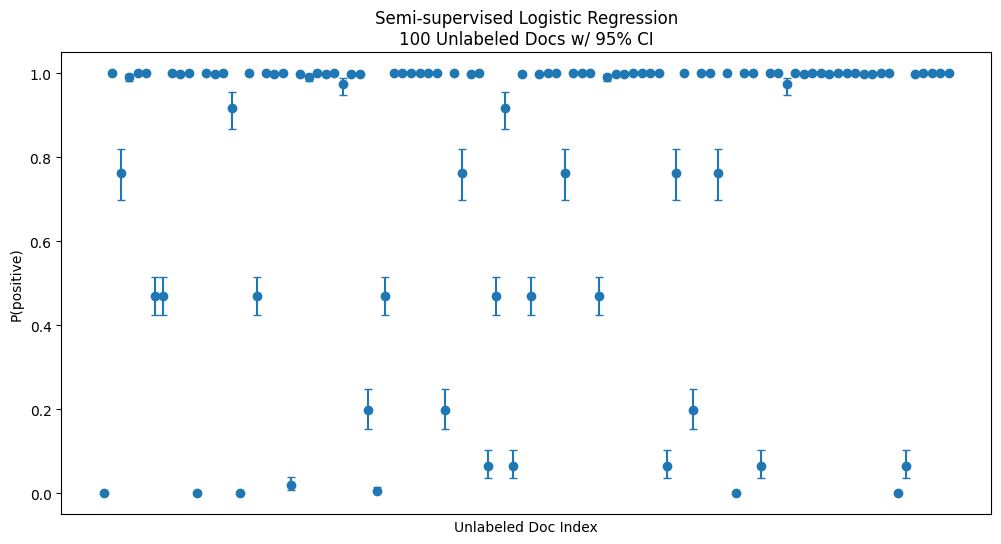

AUPRC: 0.692


In [46]:

# 5) Plot uncertainty for 100 unlabeled docs
idx_plot = idx_u[:100]
x = np.arange(len(idx_plot))
yerr = [p_mean[idx_plot] - p_lo[idx_plot], p_hi[idx_plot] - p_mean[idx_plot]]

plt.figure(figsize=(12,6))
plt.errorbar(x, p_mean[idx_plot], yerr=yerr, fmt='o', capsize=3)
plt.xticks([], [])
plt.xlabel("Unlabeled Doc Index")
plt.ylabel("P(positive)")
plt.title("Semi‑supervised Logistic Regression\n100 Unlabeled Docs w/ 95% CI")
plt.ylim(-0.05, 1.05)
plt.show()

# 6) Evaluate via AUPRC
ap = average_precision_score(labels, p_mean)
print(f"AUPRC: {ap:.3f}")

# Semi-supervised Model

In [48]:
# --- 1) Prepare: split counts & alphas just as before
# counts    : (N, V) array of word counts
# labels    : length-N array with {0,1} for NEG/POS, and we're using only idx_l as labeled
# idx_l, idx_u from train_test_split
# alpha_neg, alpha_pos are your lexicon-seeded Dirichlet hyperparameters of length V

counts_l = counts[idx_l]   # (n_l, V) labeled
y_l      = labels[idx_l]   # (n_l,)
counts_u = counts[idx_u]   # (n_u, V) unlabeled

n_l = counts_l.sum(axis=1)
n_u = counts_u.sum(axis=1)

with pm.Model() as semi_sup_mix:
    # 2) Priors
    π       = pm.Beta("π", 1, 1)
    φ_neg   = pm.Dirichlet("φ_neg", a=alpha_neg, shape=V)
    φ_pos   = pm.Dirichlet("φ_pos", a=alpha_pos, shape=V)

    # 3) Labeled‐data likelihood (we “clamp” z to the observed y_l)
    #    Documents with y_l=0 must come from φ_neg; y_l=1 from φ_pos
    pm.Multinomial(
        "obs_neg_l",
        n=n_l[y_l==0],
        p=φ_neg,
        observed=counts_l[y_l==0]
    )
    pm.Multinomial(
        "obs_pos_l",
        n=n_l[y_l==1],
        p=φ_pos,
        observed=counts_l[y_l==1]
    )

    # 4) Unlabeled‐data mixture
    comp_neg = pm.Multinomial.dist(n=n_u, p=φ_neg, size=len(n_u))
    comp_pos = pm.Multinomial.dist(n=n_u, p=φ_pos, size=len(n_u))
    pm.Mixture(
        "obs_u",
        w=[1-π, π],
        comp_dists=[comp_neg, comp_pos],
        observed=counts_u
    )

    # 5) Inference (ADVI for speed)
    approx = pm.fit(2000, method="advi")
    trace  = approx.sample(1000)

Output()

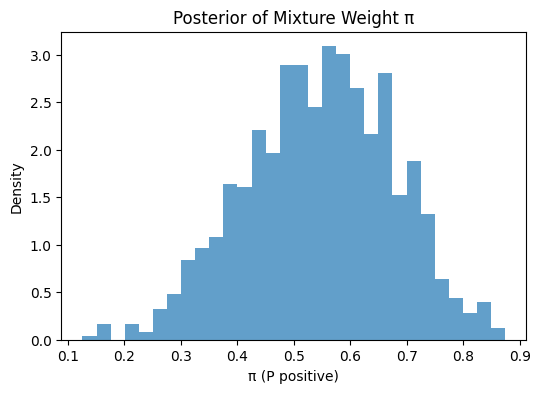

In [53]:
# 1) Extract posterior samples
phi_neg_raw = trace.posterior["φ_neg"].values
phi_pos_raw = trace.posterior["φ_pos"].values
n_chain, n_draws, V = phi_neg_raw.shape
S = n_chain * n_draws

# reshape to (S, V)
φ_neg_samps = phi_neg_raw.reshape(S, V)
φ_pos_samps = phi_pos_raw.reshape(S, V)

# mixture‐weight samples
π_samps = trace.posterior["π"].values.reshape(S)

# total docs
N = counts.shape[0]

# 2) Plot posterior of mixture weight π
plt.figure(figsize=(6,4))
plt.hist(π_samps, bins=30, density=True, alpha=0.7)
plt.title("Posterior of Mixture Weight π")
plt.xlabel("π (P positive)")
plt.ylabel("Density")
plt.show()



In [54]:
# --- 3) Compute per-document P(pos) and 95% CI
post_mean  = np.zeros(N)
post_lower = np.zeros(N)
post_upper = np.zeros(N)

for d in range(N):
    c = counts[d]             # (V,)
    # log‐likelihood under each sample s
    ll0 = (c * np.log(φ_neg_samps)).sum(axis=1)  # (S,)
    ll1 = (c * np.log(φ_pos_samps)).sum(axis=1)  # (S,)
    log0 = np.log(1 - π_samps) + ll0            # (S,)
    log1 = np.log(    π_samps) + ll1            # (S,)
    norm = logsumexp([log0, log1], axis=0)      # (S,)
    p_samps = np.exp(log1 - norm)               # (S,)
    post_mean[d]  = p_samps.mean()
    post_lower[d] = np.percentile(p_samps, 2.5)
    post_upper[d] = np.percentile(p_samps, 97.5)
    post_upper[d] = np.percentile(p_samps, 97.5)

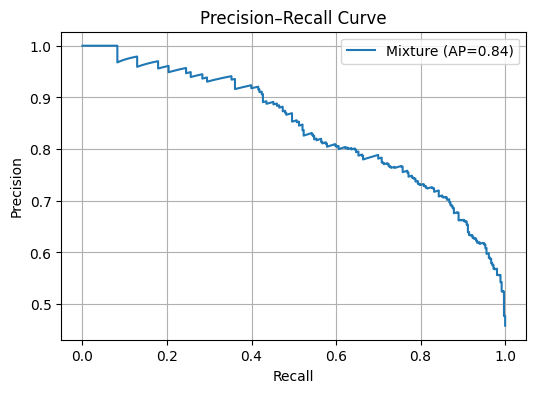

In [55]:
# --- 4) Precision–Recall curve
precision, recall, _ = precision_recall_curve(labels, post_mean)
ap_mixture = average_precision_score(labels, post_mean)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"Mixture (AP={ap_mixture:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

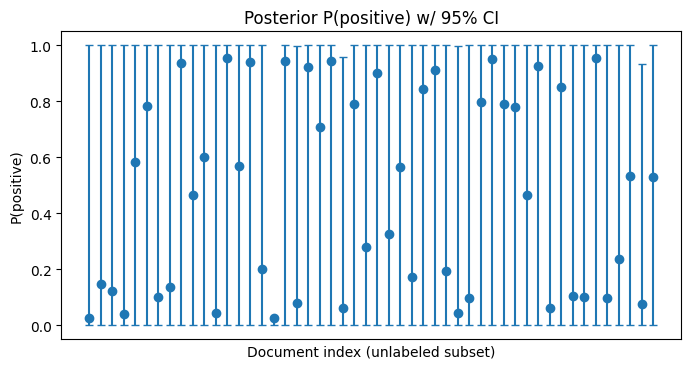

In [56]:
# --- 5) Uncertainty error-bars for first 50 unlabeled docs
idx_plot = idx_u[:50]
x        = np.arange(len(idx_plot))
yerr     = [
    post_mean[idx_plot] - post_lower[idx_plot],
    post_upper[idx_plot] - post_mean[idx_plot]
]

plt.figure(figsize=(8,4))
plt.errorbar(x, post_mean[idx_plot], yerr=yerr, fmt='o', capsize=3)
plt.xticks([], [])
plt.xlabel("Document index (unlabeled subset)")
plt.ylabel("P(positive)")
plt.title("Posterior P(positive) w/ 95% CI")
plt.ylim(-0.05, 1.05)
plt.show()


In [57]:
# --- 6) Top indicative words by posterior log-odds
phi_neg_mean = φ_neg_samps.mean(axis=0)
phi_pos_mean = φ_pos_samps.mean(axis=0)
delta = np.log(phi_pos_mean) - np.log(phi_neg_mean)

df_words = pd.DataFrame({
    "word":           vect.get_feature_names_out(),
    "log_odds_diff":  delta
})
print("Top Positive-Indicative Words:")
print(df_words.nlargest(10, "log_odds_diff").to_markdown(index=False))
print("\nTop Negative-Indicative Words:")
print(df_words.nsmallest(10, "log_odds_diff").to_markdown(index=False))

Top Positive-Indicative Words:
| word        |   log_odds_diff |
|:------------|----------------:|
| outstanding |         4.17434 |
| fantastic   |         3.9332  |
| funny       |         3.92145 |
| wow         |         3.86897 |
| adorable    |         3.73687 |
| glad        |         3.70528 |
| yummy       |         3.69076 |
| wonderful   |         3.686   |
| lucky       |         3.66916 |
| lovely      |         3.669   |

Top Negative-Indicative Words:
| word     |   log_odds_diff |
|:---------|----------------:|
| bitch    |        -4.25705 |
| ass      |        -4.14796 |
| damn     |        -4.12597 |
| hell     |        -4.10746 |
| worse    |        -3.88356 |
| damage   |        -3.8821  |
| worst    |        -3.86015 |
| boring   |        -3.85979 |
| terrible |        -3.83528 |
| kill     |        -3.83359 |


# Collocation Extraction

\begin{array}{c|cc}
& w_2 & \neg w_2 \\ \hline
w_1    & n_{11} & n_{10}\\
\neg w_1 & n_{01} & n_{00}
\end{array}

$\quad\text{with}\quad
N = n_{11}+n_{10}+n_{01}+n_{00}$


Define two Bernoulli parameters

$\theta = P(w_2\mid w_1),\qquad
\phi   = P(w_2\mid \neg w_1)$


Put conjugate Beta priors

$\theta\sim \mathrm{Beta}(\alpha,\alpha),
\quad
\phi  \sim \mathrm{Beta}(\alpha,\alpha)$


Observe data
$n_{11}$ “successes” out of $n_{1\cdot}=n_{11}+n_{10}$ trials for $\theta$,
and $n_{01}$ successes out of $n_{\cdot1}=n_{01}+n_{00}$ for $\phi$


Posterior
$\theta\mid\text{data}
\;\sim\;
\mathrm{Beta}(\alpha + n_{11},\,\alpha + n_{10}),
\quad
\phi\mid\text{data}
\;\sim\;
\mathrm{Beta}(\alpha + n_{01},\,\alpha + n_{00})$


Collocation score
We look at the log‐odds ratio

$\Delta = \log\frac{\theta/(1-\theta)}{\phi/(1-\phi)}
\;=\;logit(\theta)-logit(\phi)$


To get uncertainty, draw posterior samples
$\{\theta^{(s)},\phi^{(s)}\}$ and compute
$\Delta^{(s)}$, then summarize
$\mathbb{E}[\Delta]$ and its 95% credible interval.


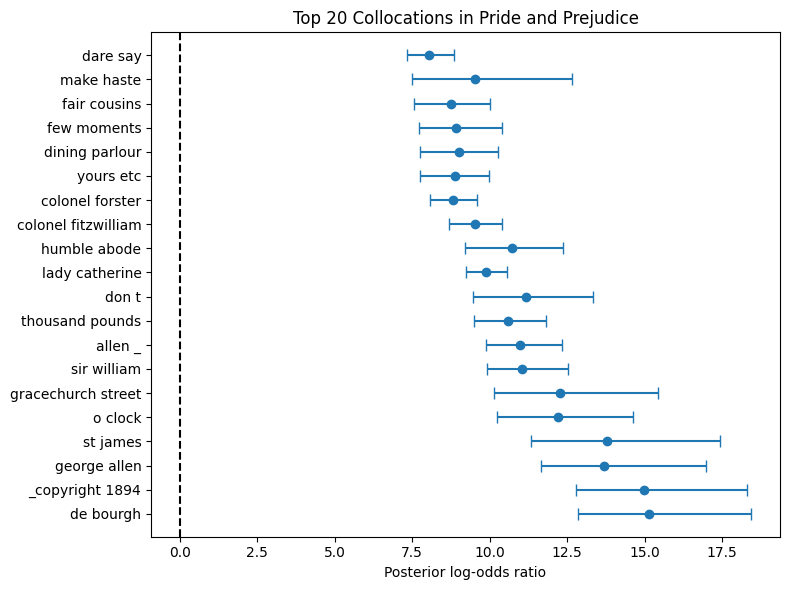

| bigram              |   count |     mean |   ci_low |   ci_high |
|:--------------------|--------:|---------:|---------:|----------:|
| de bourgh           |      41 | 15.144   | 12.864   |  18.4439  |
| _copyright 1894     |      34 | 14.9827  | 12.7815  |  18.2947  |
| george allen        |      37 | 13.6784  | 11.6714  |  16.9674  |
| st james            |       6 | 13.7802  | 11.319   |  17.4337  |
| o clock             |       5 | 12.1983  | 10.2483  |  14.6392  |
| gracechurch street  |       9 | 12.2839  | 10.1372  |  15.4359  |
| sir william         |      44 | 11.0381  |  9.90772 |  12.521   |
| allen _             |      34 | 10.9928  |  9.88381 |  12.3217  |
| thousand pounds     |      20 | 10.5824  |  9.48127 |  11.8097  |
| don t               |       6 | 11.1822  |  9.4621  |  13.3246  |
| lady catherine      |     122 |  9.87961 |  9.23894 |  10.567   |
| humble abode        |       5 | 10.7213  |  9.2069  |  12.3778  |
| colonel fitzwilliam |      30 |  9.52007 |  8.

In [59]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

url = "https://www.gutenberg.org/files/1342/1342-0.txt"
text = requests.get(url).text

# 1) Tokenize
tokens = re.findall(r"\b\w+\b", text.lower())
N = len(tokens)

# 2) Count unigrams & bigrams
unigram_counts = Counter(tokens)
bigram_counts  = Counter(zip(tokens, tokens[1:]))

# 3) Compute posterior log-odds for each bigram
alpha = 1.0   # Beta prior pseudocount
S     = 2000  # posterior samples

records = []
for (w1, w2), n11 in bigram_counts.items():
    if n11 < 5:
        continue  # skip very rare pairs
    n1_dot = unigram_counts[w1]
    n_dot1 = unigram_counts[w2]
    n10 = n1_dot - n11
    n01 = n_dot1 - n11
    n00 = N - n11 - n10 - n01

    # posteriors
    a1, b1 = alpha + n11, alpha + n10
    a2, b2 = alpha + n01, alpha + n00

    θ = beta.rvs(a1, b1, size=S)
    φ = beta.rvs(a2, b2, size=S)
    δ = np.log(θ/(1-θ)) - np.log(φ/(1-φ))

    records.append({
        "bigram":   f"{w1} {w2}",
        "count":    n11,
        "mean":     δ.mean(),
        "ci_low":   np.percentile(δ, 2.5),
        "ci_high":  np.percentile(δ, 97.5),
    })

df = pd.DataFrame(records)

# 4) Select top 20 by lower CI bound
df_top = df.nlargest(20, "ci_low").reset_index(drop=True)

# 5) Forest plot
plt.figure(figsize=(8,6))
y = np.arange(len(df_top))
plt.errorbar(df_top["mean"], y,
             xerr=[df_top["mean"]-df_top["ci_low"],
                   df_top["ci_high"]-df_top["mean"]],
             fmt='o', capsize=4)
plt.yticks(y, df_top["bigram"])
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Posterior log-odds ratio")
plt.title("Top 20 Collocations in Pride and Prejudice")
plt.tight_layout()
plt.show()

# 6) Display results
print(df_top[["bigram","count","mean","ci_low","ci_high"]].to_markdown(index=False))